In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from tensorflow.keras.models import load_model

sb.set(context='talk', style='white', palette='Set1')
plt.rcParams["font.family"] = "serif"

sys.path.insert(0, '/home/ubuntu/Documents/NMDinStars/mcmc/')
from ML_Helpers import inverseMinNormalize, minNormalize, norm1

In [2]:
# read in ML algorithms

classifier = load_model('/home/ubuntu/Documents/NMDinStars/ML_models/classifier/classify_mesa.h5')
regressor = load_model('/home/ubuntu/Documents/NMDinStars/ML_models/regressor/IBand.h5')  

In [46]:
def ML(theta):
    '''
    Use the ML classiifer and regressor to predict the I-Band
    magnitudes given mass, Y, Z, mu_12
    '''
    # read in normalization constants
    #constReg = pd.read_csv('/home/ubuntu/Documents/NMDinStars/ML_models/regressor/regression_norm_const.txt', index_col=0)
    #constClass = pd.read_csv('/home/ubuntu/Documents/NMDinStars/ML_models/classifier/classify_norm_const.txt', index_col=0)
    const = pd.read_csv('/home/ubuntu/Documents/NMDinStars/ML_models/norm_const.txt', index_col=0)
    # normalize the input vector
    m, y, z, mu = theta
    
    m = norm1(m, const['min'].loc['mass'], const['max'].loc['mass'])
    y = norm1(y, const['min'].loc['y'], const['max'].loc['y'])
    z = norm1(z, const['min'].loc['z'], const['max'].loc['z'])
    mu = norm1(mu, const['min'].loc['mu'], const['max'].loc['mu'])
    thetaNorm = np.array([m, y, z, mu])[None,:]
    #print(thetaNorm)
    # call the ML models
    flag = classifier(thetaNorm).numpy()
    
    flag = np.argmax(flag)
    
    #if flag != 0:
        #return -np.inf, -np.inf, flag
    
    IbandNorm, IerrNorm = regressor(thetaNorm).numpy()[0]
    
    # denormalize Iband and Ierr
    Iband = inverseMinNormalize(IbandNorm,
                                const['min'].loc['M_I'],
                                const['max'].loc['M_I'])
    Ierr = inverseMinNormalize(IerrNorm,
                               const['min'].loc['M_I_err'],
                               const['max'].loc['M_I_err'])
    
    return Iband, Ierr, flag

In [47]:
mu12 = [0, 2, 4]
n = 1000

def IMF_prob(x):
    norm = 2.25**-1.35 - 0.7**-1.35
    eq = x*norm + 0.7**-1.35
    return eq**(-20/27)
    
# randomly sample n points from mass, y, and z
yVals = np.random.uniform(low=0.2, high=0.3, size=n) # sample from uniform distribution
zVals = np.random.normal(loc=0.0091, scale=0.0007, size=n) # sample from gaussian

mVals = IMF_prob(np.random.uniform(low=0, high=1, size=n))

allIbands = []

for mu in mu12:
    # run the ML algorithms given each point in the parameter space
    Ibands = []
    for m, y, z in zip(mVals, yVals, zVals):

        theta = [m, y, z, mu]
        Iband, Ierr, flag = ML(theta)

        Ibands.append(Iband)
        
    allIbands.append(np.array(Ibands))

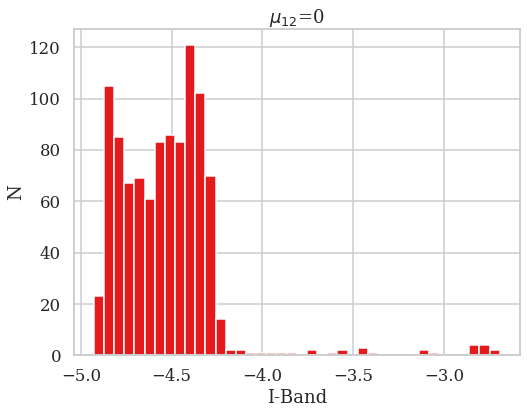

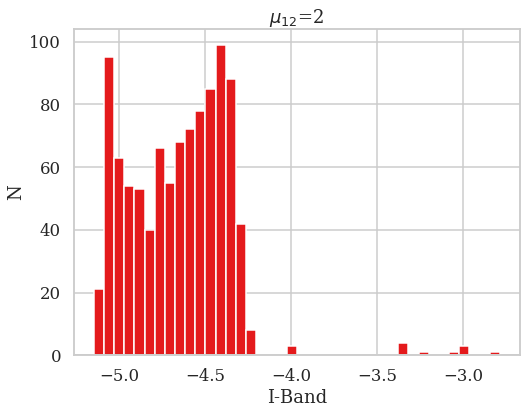

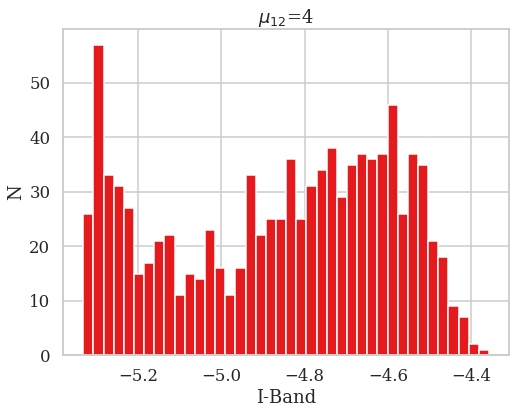

In [49]:
for i, mu in zip(allIbands, mu12):
    Ibands = i[np.isfinite(i)]
    
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.hist(Ibands, bins=40)
    ax.set_xlabel('I-Band')
    ax.set_ylabel('N')
    ax.set_title(r'$\mu_{12}$='+str(mu))

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))

x = np.linspace(0.7, 2.5, 100)
ax.plot(x, x**-2.35, '-', label='IMF')
ax.hist(mVals, density=True, label='MC Sampling')
ax.legend()

In [ ]:
toPlot = mVals
label = 'Mass'
for i, mu in zip(allIbands, mu12):
    Ibands = i[np.isfinite(i)]
    M = toPlot[np.isfinite(i)]

    fig, ax = plt.subplots(1, figsize=(8,6))

    ax.plot(M, Ibands, '.')
    ax.set_ylabel('I-Band')
    ax.set_xlabel(label)
    ax.set_title(r'$\mu_{12}$='+str(mu))

In [ ]:
nBins = 50
mBins = np.linspace(0.7, 2.25, nBins)

for Ibands, mu in zip(allIbands, mu12):
    
    Iband = Ibands[np.isfinite(Ibands)]
    M = mVals[np.isfinite(Ibands)]
    
    binnedI = [Iband[np.where((M > low) * (M < high))[0]] for low, high in zip(mBins[:-1], mBins[1:])]
    
    print(len(binnedI))
    
    Ibins = [np.mean(I) for I in binnedI]
    Ierr = [np.std(I) for I in binnedI]

    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.errorbar(mBins[:-1], Ibins, yerr=Ierr, fmt='o')
    ax.set_xlabel('Mass')
    ax.set_ylabel('I-Band Magnitude')
    ax.set_title(r'$\mu_{12}$='+str(mu))

In [ ]:
df = pd.read_csv('~/Documents/NMDinStars/analysis/output_analysis/allData.csv')
mu0 = df[df.mu == 0]
mu0 = df[df.flag==0]

fig, ax = plt.subplots()

group = mu0.groupby(mu0.mass).mean().reset_index()
std = mu0.groupby(mu0.mass).std()
ax.errorbar(group.mass, group.M_I, yerr=std.M_I, fmt='o', label=r'Average M$_I$', capsize=6)

In [ ]:
fig, ax = plt.subplots()

group = []
std = []
for i in range(0, len(mu0.mass.unique()), 2):
    m = mu0.mass.unique()[i]
    
    where = np.where(abs(mu0.mass - m) < 0.05)[0]
    good = mu0.iloc[where]
    group.append(np.mean(good))
    std.append(np.std(good))
    
group = pd.concat(group, axis=1).T
std = pd.concat(std, axis=1).T
    
ax.errorbar(group.mass, group.M_I, yerr=std.M_I, fmt='o', label=r'Average M$_I$', capsize=6)
ax.set_xlabel('Mass')
ax.set_ylabel('I-Band Magnitude')

In [ ]:
np.sort(mu0.mass.unique())